# Basic models
## Loading data

In [2]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
%load_ext autoreload
%autoreload 2

In [3]:
%run proj1_helpers.py
%run implementations.py

In [4]:
DATA_TRAIN_PATH = 'train.csv' # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
tx = copy.deepcopy(tX)

## Cleaning data

In [5]:
tx = np.where(tx==-999, np.nan, tx) # replace -999 value with nan

In [6]:
col_mean = np.nanmean(tx, axis=0)
inds_nan = np.where(np.isnan(tx))
tx[inds_nan] = np.take(col_mean, inds_nan[1])

In [200]:
#CELL NOT USED
tx_stand,_,_ = standardize(tx)

In [201]:
#CELL NOT USED
tx = np.insert(tx, 0, 1, axis=1)
tx_stand = np.insert(tx_stand, 0, 1, axis=1)

## Split data

In [255]:
#CELL NOT USED
ratio_train_test = 0.8
x_train, y_train, x_test, y_test = split_data(tx_stand, y, ratio_train_test, seed=1)
x_train_ns, y_train_ns, x_test_ns, y_test_ns = split_data(tx, y, ratio_train_test, seed=1)

In [295]:
##CELL NOT USED
ratio_train_test = 0.8
x_train, y_train, x_test, y_test = split_data(tx, y, ratio_train_test, seed=1234)
x_train_ns, y_train_ns, x_test_ns, y_test_ns = split_data(tx, y, ratio_train_test, seed=1234)

In [296]:
##CELL NOT USED
x_train,_,_ = standardize(copy.deepcopy(x_train))
x_train = np.insert(x_train, 0, 1, axis=1)
x_test,_,_ = standardize(copy.deepcopy(x_test))
x_test = np.insert(x_test, 0, 1, axis=1)
x_train_ns = np.insert(x_train_ns, 0, 1, axis=1)
x_test_ns = np.insert(x_test_ns, 0, 1, axis=1)

## Cross-validation

In [7]:
#Divide the data into 5 parts
num_folds = 5
shuffled_indices = np.arange(tx.shape[0])
np.random.seed(1)
np.random.shuffle(shuffled_indices)
folds_indices = np.array_split(shuffled_indices, num_folds)
x_folds = []
y_folds = []
for fold in folds_indices:
    x_folds.append(tx[fold])
    y_folds.append(y[fold])

In [8]:
# Put those parts together to make 5 train/test splits
x_train = []
x_test = []
x_train_ns = []
x_test_ns = []
y_train = []
y_test = []
for i in range(num_folds):
    x_test_ns.append(x_folds[i])
    y_test.append(y_folds[i])
    indices = [j for j in range(num_folds) if j != i]
    x_train_ns.append(np.concatenate([x_folds[j] for j in indices]))
    y_train.append(np.concatenate([y_folds[j] for j in indices]))
    #standardize
    x_train.append(standardize(copy.deepcopy(x_train_ns[i]))[0])
    x_test.append(standardize(copy.deepcopy(x_test_ns[i]))[0])
    #insert column of ones
    x_train_ns[i] = np.insert(x_train_ns[i], 0, 1, axis=1)
    x_test_ns[i] = np.insert(x_test_ns[i], 0, 1, axis=1)
    x_train[i] = np.insert(x_train[i], 0, 1, axis=1)
    x_test[i] = np.insert(x_test[i], 0, 1, axis=1)

## Linear Regression with Gradient Descent

In [9]:
cat_accuracies_train = []
cat_accuracies_test = []
f1_scores_train = []
f1_scores_test = []
for i in range(num_folds):
    weights_LSGD1 = least_squares_GD(y_train[i], x_train[i], np.zeros(31), 100, 0.000001)[0]
    cat_accuracy_train, f1_score_train = metrics(y_train[i], predict_labels(weights_LSGD1, x_train[i]))
    cat_accuracy_test, f1_score_test = metrics(y_test[i], predict_labels(weights_LSGD1, x_test[i]))
    cat_accuracies_train.append(cat_accuracy_train)
    cat_accuracies_test.append(cat_accuracy_test)
    f1_scores_train.append(f1_score_train)
    f1_scores_test.append(f1_score_test)

print("Categorical accuracy train : ",cat_accuracies_train," || f1_score train: ",f1_scores_train)
print("Categorical accuracy test : ",cat_accuracies_test," || f1_score test: ",f1_scores_test)
print("Categorical accuracy train mean: ",np.mean(cat_accuracies_train), " stdev: ", np.std(cat_accuracies_train))
print("Categorical accuracy test mean: ",np.mean(cat_accuracies_test), " stdev: ", np.std(cat_accuracies_test))

Categorical accuracy train :  [0.70101, 0.70141, 0.70037, 0.70119, 0.70122]  || f1_score train:  [0.30688547350064127, 0.3068926400623064, 0.30511347265300587, 0.3058169774080694, 0.3063047804547572]
Categorical accuracy test :  [0.70098, 0.69896, 0.70346, 0.70072, 0.7006]  || f1_score test:  [0.3048548955790616, 0.3047974232920834, 0.30732252276651206, 0.3068926400623064, 0.306577253945675]
Categorical accuracy train mean:  0.7010400000000001  stdev:  0.00035821781083578065
Categorical accuracy test mean:  0.700944  stdev:  0.0014447366542037871


In [10]:
def least_squares_GD_cv(y, x, test_y, test_x, w_i, max_iter, gamma):
    cat_accuracies_train = []
    cat_accuracies_test = []
    f1_scores_train = []
    f1_scores_test = []
    for i in range(num_folds):
        weights_LSGD1 = least_squares_GD(y[i], x[i], w_i, max_iter, gamma)[0]
        cat_accuracy_train, f1_score_train = metrics(y[i], predict_labels(weights_LSGD1, x[i]))
        cat_accuracy_test, f1_score_test = metrics(test_y[i], predict_labels(weights_LSGD1, test_x[i]))
        cat_accuracies_train.append(cat_accuracy_train)
        cat_accuracies_test.append(cat_accuracy_test)
        f1_scores_train.append(f1_score_train)
        f1_scores_test.append(f1_score_test)
    return cat_accuracies_train, cat_accuracies_test

In [11]:
gammas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.31, 0.32, 0.33, 0.34, 0.4, 0.5]
accuracies_train_mean1 = []
accuracies_test_mean1 = []
accuracies_train_std1 = []
accuracies_test_std1 = []
for gamma in gammas:
    cat_accuracies_train, cat_accuracies_test = least_squares_GD_cv(y_train, x_train, y_test, x_test, np.zeros(31), 100, gamma)
    
    print("Gamma: " + str(gamma) + " || Categorical accuracy train : (",np.mean(cat_accuracies_train),", ", np.std(cat_accuracies_train),")")
    print("Gamma: " + str(gamma) + " || Categorical accuracy test : (",np.mean(cat_accuracies_test),", ", np.std(cat_accuracies_test),")")
    accuracies_train_mean1.append(np.mean(cat_accuracies_train))
    accuracies_test_mean1.append(np.mean(cat_accuracies_test))
    accuracies_train_std1.append(np.std(cat_accuracies_train))
    accuracies_test_std1.append(np.std(cat_accuracies_test))
    
print(accuracies_train_mean1)
print(accuracies_test_mean1)
print(accuracies_train_std1)
print(accuracies_test_std1)

Gamma: 1e-06 || Categorical accuracy train : ( 0.7010400000000001 ,  0.00035821781083578065 )
Gamma: 1e-06 || Categorical accuracy test : ( 0.700944 ,  0.0014447366542037871 )
Gamma: 1e-05 || Categorical accuracy train : ( 0.70108 ,  0.00036297382825763023 )
Gamma: 1e-05 || Categorical accuracy test : ( 0.7009559999999999 ,  0.0014701510126514169 )
Gamma: 0.0001 || Categorical accuracy train : ( 0.7015100000000001 ,  0.00044707941129065265 )
Gamma: 0.0001 || Categorical accuracy test : ( 0.7015 ,  0.0015816447135814059 )
Gamma: 0.001 || Categorical accuracy train : ( 0.705468 ,  0.00039593686365378835 )
Gamma: 0.001 || Categorical accuracy test : ( 0.705444 ,  0.0012901100728232213 )
Gamma: 0.01 || Categorical accuracy train : ( 0.7248060000000001 ,  0.000568545512690078 )
Gamma: 0.01 || Categorical accuracy test : ( 0.7247679999999999 ,  0.0022847179256967293 )
Gamma: 0.05 || Categorical accuracy train : ( 0.7369410000000001 ,  0.0006012769744468879 )
Gamma: 0.05 || Categorical accura

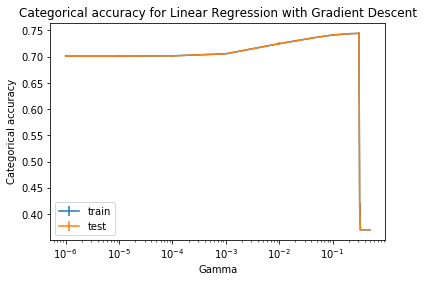

In [12]:
plt.errorbar(gammas[:], accuracies_train_mean1, yerr=accuracies_train_std1, label="train")
plt.errorbar(gammas[:], accuracies_test_mean1, yerr=accuracies_test_std1, label="test")
plt.xscale("log")
plt.xlabel("Gamma")
plt.ylabel("Categorical accuracy")
plt.title("Categorical accuracy for Linear Regression with Gradient Descent")
plt.legend()
plt.show()

In [423]:
np.array(accuracies_train_mean1) - np.array(accuracies_test_mean1)

array([ 9.60e-05,  1.24e-04,  1.00e-05,  2.40e-05,  3.80e-05,  1.29e-04,
       -2.00e-06, -9.20e-05, -5.50e-05, -9.70e-05,  1.68e-04, -4.90e-05,
       -2.90e-05, -2.80e-05, -2.80e-05])

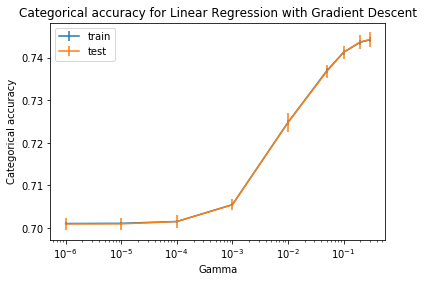

In [13]:
plt.errorbar(gammas[:9], accuracies_train_mean1[:9], yerr=accuracies_train_std1[:9], label="train")
plt.errorbar(gammas[:9], accuracies_test_mean1[:9], yerr=accuracies_test_std1[:9], label="test")
plt.xscale("log")
plt.xlabel("Gamma")
plt.ylabel("Categorical accuracy")
plt.title("Categorical accuracy for Linear Regression with Gradient Descent")
plt.legend()
plt.show()

In [14]:
print("Best performance: gamma ", gammas[np.argmax(accuracies_train_mean1)], ", train accuracy: ", accuracies_train_mean1[np.argmax(accuracies_train_mean1)], ", test accuracy: ", accuracies_train_mean1[np.argmax(accuracies_train_mean1)], ", std: ", accuracies_train_std1[np.argmax(accuracies_train_mean1)])

Best performance: gamma  0.31 , train accuracy:  0.744391 , test accuracy:  0.744391 , std:  0.0005096802919478008


In [48]:
%time weights_LSGD1 = least_squares_GD(y_train[0], x_train[0], np.zeros(31), 100, 0.31)[0]
print(weights_LSGD1)

Wall time: 931 ms
[-3.13130000e-01  7.08601533e-03 -2.55704445e-01 -2.53742409e-01
 -2.23842350e-03  2.40628424e-02  8.81081511e-02  4.63328228e-03
  2.77105802e-01 -2.82107748e-02  6.25935359e-02 -1.76302816e-01
  1.17095501e-01  7.60924665e-02  1.77424342e-01 -1.39096964e-03
 -2.54160458e-03  2.63020309e-01 -1.07656703e-04  2.39270733e-03
  1.04371178e-01  2.17604174e-03 -4.99052975e-02  2.80071808e-02
 -5.50856085e-02  9.14066604e-04  5.14744781e-04 -4.19412417e-02
  1.49303342e-03 -5.15073324e-04 -2.59649759e-02]


In [16]:
%%time
cat_accuracy_test, f1_score_test = metrics(y_test[0], predict_labels(weights_LSGD1, x_test[0]))
print(cat_accuracy_test)

0.74338
Wall time: 93.7 ms


### Least Squares GD with non-standardized data

In [428]:
gammas = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.31, 0.32, 0.33, 0.34, 0.4, 0.5]
accuracies_train_mean2 = []
accuracies_test_mean2 = []
accuracies_train_std2 = []
accuracies_test_std2 = []
for gamma in gammas:
    cat_accuracies_train, cat_accuracies_test = least_squares_GD_cv(y_train, x_train_ns, y_test, x_test_ns, np.zeros(31), 100, gamma)
    
    print("Gamma: " + str(gamma) + " || Categorical accuracy train : (",np.mean(cat_accuracies_train),", ", np.std(cat_accuracies_train),")")
    print("Gamma: " + str(gamma) + " || Categorical accuracy test : (",np.mean(cat_accuracies_test),", ", np.std(cat_accuracies_test),")")
    accuracies_train_mean2.append(np.mean(cat_accuracies_train))
    accuracies_test_mean2.append(np.mean(cat_accuracies_test))
    accuracies_train_std2.append(np.std(cat_accuracies_train))
    accuracies_test_std2.append(np.std(cat_accuracies_test))
    
print(accuracies_train_mean2)
print(accuracies_test_mean2)
print(accuracies_train_std2)
print(accuracies_test_std2)

Gamma: 1e-07 || Categorical accuracy train : ( 0.657332 ,  0.0004281775332733195 )
Gamma: 1e-07 || Categorical accuracy test : ( 0.657332 ,  0.001712710133093164 )
Gamma: 1e-06 || Categorical accuracy train : ( 0.6655960000000001 ,  0.0002944554295644445 )
Gamma: 1e-06 || Categorical accuracy test : ( 0.665576 ,  0.0016871941204259547 )
Gamma: 1e-05 || Categorical accuracy train : ( 0.34266800000000003 ,  0.00042817753327328243 )
Gamma: 1e-05 || Categorical accuracy test : ( 0.34266800000000003 ,  0.0017127101330931612 )
Gamma: 0.0001 || Categorical accuracy train : ( 0.34266800000000003 ,  0.00042817753327328243 )
Gamma: 0.0001 || Categorical accuracy test : ( 0.34266800000000003 ,  0.0017127101330931612 )
Gamma: 0.001 || Categorical accuracy train : ( 0.34266800000000003 ,  0.00042817753327328243 )
Gamma: 0.001 || Categorical accuracy test : ( 0.34266800000000003 ,  0.0017127101330931612 )
Gamma: 0.01 || Categorical accuracy train : ( 0.657332 ,  0.0004281775332733195 )
Gamma: 0.01 |

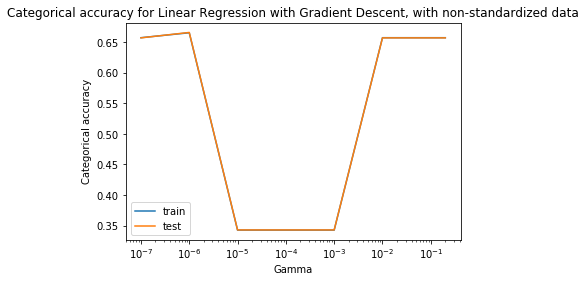

In [278]:
plt.plot(gammas[:9], accuracies_train_2[:9], label="train")
plt.plot(gammas[:9], accuracies_test_2[:9], label="test")
plt.xscale("log")
plt.xlabel("Gamma")
plt.ylabel("Categorical accuracy")
plt.title("Categorical accuracy for Linear Regression with Gradient Descent, with non-standardized data")
plt.legend()
plt.show()

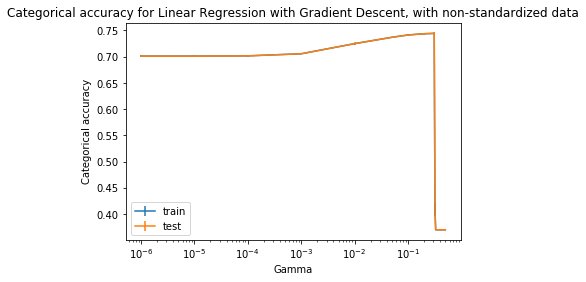

In [426]:
plt.errorbar(gammas[:], accuracies_train_mean2[:], yerr=accuracies_train_std2[:], label="train")
plt.errorbar(gammas[:], accuracies_test_mean2[:], yerr=accuracies_test_std2[:], label="test")
plt.xscale("log")
plt.xlabel("Gamma")
plt.ylabel("Categorical accuracy")
plt.title("Categorical accuracy for Linear Regression with Gradient Descent, with non-standardized data")
plt.legend()
plt.show()

## Linear Regression with Stochastic Gradient Descent

In [405]:
def least_squares_SGD_cv(y_train, x_train, w_i, max_iter, gamma):
    cat_accuracies_train = []
    cat_accuracies_test = []
    f1_scores_train = []
    f1_scores_test = []
    for i in range(num_folds):
        weights = least_squares_SGD(y_train[i], x_train[i], w_i, max_iter, gamma)[0]
        cat_accuracy_train, f1_score_train = metrics(y_train[i], predict_labels(weights, x_train[i]))
        cat_accuracy_test, f1_score_test = metrics(y_test[i], predict_labels(weights, x_test[i]))
        cat_accuracies_train.append(cat_accuracy_train)
        cat_accuracies_test.append(cat_accuracy_test)
        f1_scores_train.append(f1_score_train)
        f1_scores_test.append(f1_score_test)
    return cat_accuracies_train, cat_accuracies_test

In [449]:
gammas = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.31, 0.32, 0.33, 0.34, 0.4, 0.5]
accuracies_train_mean3 = []
accuracies_test_mean3 = []
accuracies_train_std3 = []
accuracies_test_std3 = []
for gamma in gammas:
    cat_accuracies_train, cat_accuracies_test = least_squares_SGD_cv(y_train, x_train, np.zeros(31), 100, gamma)
    
    print("Gamma: " + str(gamma) + " || Categorical accuracy train : (",np.mean(cat_accuracies_train),", ", np.std(cat_accuracies_train),")")
    print("Gamma: " + str(gamma) + " || Categorical accuracy test : (",np.mean(cat_accuracies_test),", ", np.std(cat_accuracies_test),")")
    accuracies_train_mean3.append(np.mean(cat_accuracies_train))
    accuracies_test_mean3.append(np.mean(cat_accuracies_test))
    accuracies_train_std3.append(np.std(cat_accuracies_train))
    accuracies_test_std3.append(np.std(cat_accuracies_test))
    
print(accuracies_train_mean3)
print(accuracies_test_mean3)
print(accuracies_train_std3)
print(accuracies_test_std3)

Gamma: 1e-07 || Categorical accuracy train : ( 0.6805560000000002 ,  0.02070836797046061 )
Gamma: 1e-07 || Categorical accuracy test : ( 0.680652 ,  0.018223359075647955 )
Gamma: 1e-06 || Categorical accuracy train : ( 0.6815289999999999 ,  0.007880309892383678 )
Gamma: 1e-06 || Categorical accuracy test : ( 0.6809000000000001 ,  0.00844370534777239 )
Gamma: 1e-05 || Categorical accuracy train : ( 0.696086 ,  0.009965198643278503 )
Gamma: 1e-05 || Categorical accuracy test : ( 0.6957239999999999 ,  0.011083468049306582 )
Gamma: 0.0001 || Categorical accuracy train : ( 0.687024 ,  0.01932466646542704 )
Gamma: 0.0001 || Categorical accuracy test : ( 0.684868 ,  0.01790933432598768 )
Gamma: 0.001 || Categorical accuracy train : ( 0.683438 ,  0.01807710225672246 )
Gamma: 0.001 || Categorical accuracy test : ( 0.683652 ,  0.018188425330412743 )
Gamma: 0.01 || Categorical accuracy train : ( 0.669627 ,  0.039975058298894334 )
Gamma: 0.01 || Categorical accuracy test : ( 0.670596 ,  0.03892796

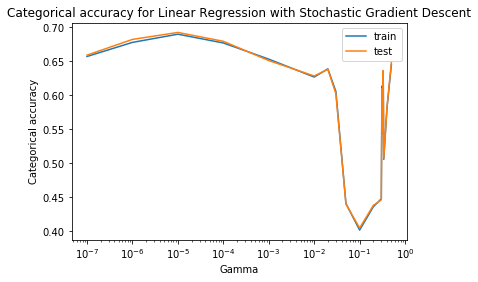

In [407]:
plt.plot(gammas[:], accuracies_train_3[:], label="train")
plt.plot(gammas[:], accuracies_test_3[:], label="test")
plt.xscale("log")
plt.xlabel("Gamma")
plt.ylabel("Categorical accuracy")
plt.title("Categorical accuracy for Linear Regression with Stochastic Gradient Descent")
plt.legend()
plt.show()

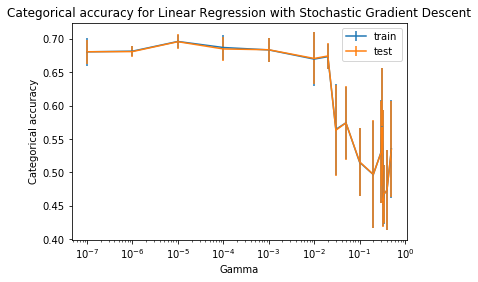

In [450]:
plt.errorbar(gammas[:], accuracies_train_mean3[:], yerr=accuracies_train_std3[:], label="train")
plt.errorbar(gammas[:], accuracies_test_mean3[:], yerr=accuracies_test_std3[:], label="test")
plt.xscale("log")
plt.xlabel("Gamma")
plt.ylabel("Categorical accuracy")
plt.title("Categorical accuracy for Linear Regression with Stochastic Gradient Descent")
plt.legend()
plt.show()

In [451]:
print("Best performance: gamma ", gammas[np.argmax(accuracies_train_mean3)], ", train accuracy: ", accuracies_train_mean3[np.argmax(accuracies_train_mean3)], ", test accuracy: ", accuracies_test_mean3[np.argmax(accuracies_train_mean3)], ", std: ", accuracies_train_std3[np.argmax(accuracies_train_mean3)])

Best performance: gamma  1e-05 , train accuracy:  0.696086 , test accuracy:  0.6957239999999999 , std:  0.009965198643278503


In [46]:
%time weights_LSSGD1 = least_squares_SGD(y_train[0], x_train[0], np.zeros(31), 100, 0.00001)[0]
print(weights_LSSGD1)

Wall time: 11 ms
[-1.60043091e-04  2.82092403e-05 -2.43397004e-04  1.74676572e-05
  4.84123325e-05  8.47379756e-05  4.14929252e-05 -1.17459224e-04
  4.85951117e-05 -1.04668948e-06  6.32848868e-06 -2.52299449e-04
  1.13216405e-04  1.75207899e-04  2.61783414e-04 -1.22122960e-04
  3.72632938e-05 -6.14085614e-05 -1.58243799e-04 -4.59572131e-05
 -3.24962153e-06  5.39713979e-05 -1.12415051e-04  1.71732846e-05
 -1.26414596e-04 -2.76566119e-05 -3.98097694e-05 -8.10260673e-05
 -3.18344081e-05 -2.16245228e-05 -3.83512081e-05]


In [33]:
%%time
cat_accuracy_test, f1_score_test = metrics(y_test[0], predict_labels(weights_LSSGD1, x_test[0]))
print(cat_accuracy_test)

NameError: name 'weights_LSSGD1' is not defined

## Least Squares

In [424]:
def least_squares_cv(y_train, x_train, y_test, x_test):
    cat_accuracies_train = []
    cat_accuracies_test = []
    f1_scores_train = []
    f1_scores_test = []
    for i in range(num_folds):
        weights = least_squares(y_train[i], x_train[i])[0]
        cat_accuracy_train, f1_score_train = metrics(y_train[i], predict_labels(weights, x_train[i]))
        cat_accuracy_test, f1_score_test = metrics(y_test[i], predict_labels(weights, x_test[i]))
        cat_accuracies_train.append(cat_accuracy_train)
        cat_accuracies_test.append(cat_accuracy_test)
        f1_scores_train.append(f1_score_train)
        f1_scores_test.append(f1_score_test)
    return cat_accuracies_train, cat_accuracies_test

In [425]:
cat_accuracies_train4, cat_accuracies_test4 = least_squares_cv(y_train, x_train, y_test, x_test)

print("Categorical accuracy train : (",np.mean(cat_accuracies_train4),", ", np.std(cat_accuracies_train4),")")
print("Categorical accuracy test : (",np.mean(cat_accuracies_test4),", ", np.std(cat_accuracies_test4),")")

Categorical accuracy train : ( 0.744493 ,  0.0006400749956060015 )
Categorical accuracy test : ( 0.706348 ,  0.021547419706312843 )


In [32]:
%time weights_LS = least_squares(y_train[0], x_train[0])[0]
print(weights_LS)

Wall time: 35.9 ms
[-3.13130000e-01  1.05475629e-02 -2.56438955e-01 -2.64020033e-01
 -3.80177226e-03  2.27716610e-02  8.92120020e-02  4.35561312e-03
  2.82055477e-01 -2.77485131e-02 -3.51835905e+01 -1.87273104e-01
  1.17102656e-01  7.61178986e-02  6.98004258e+00 -1.39537393e-03
 -2.46978642e-03  7.01990616e+00 -5.35820157e-05  2.38873367e-03
  1.06417393e-01  2.16975969e-03 -4.91944796e-02  3.46963071e-02
 -5.17441641e-02  9.39297005e-04  4.96717719e-04 -4.05398626e-02
  1.49469672e-03 -5.36661183e-04  2.98086548e+01]


## Ridge regression

In [77]:
def ridge_regression_cv(y_train, x_train, y_test, x_test, lambda_):
    cat_accuracies_train = []
    cat_accuracies_test = []
    f1_scores_train = []
    f1_scores_test = []
    for i in range(num_folds):
        weights = ridge_regression(y_train[i], x_train[i], lambda_)[0]
        cat_accuracy_train, f1_score_train = metrics(y_train[i], predict_labels(weights, x_train[i]))
        cat_accuracy_test, f1_score_test = metrics(y_test[i], predict_labels(weights, x_test[i]))
        cat_accuracies_train.append(cat_accuracy_train)
        cat_accuracies_test.append(cat_accuracy_test)
        f1_scores_train.append(f1_score_train)
        f1_scores_test.append(f1_score_test)
    return cat_accuracies_train, cat_accuracies_test

In [415]:
lambdas =  np.logspace(-6, 12, 40)
accuracies_train_mean5 = []
accuracies_test_mean5 = []
accuracies_train_std5 = []
accuracies_test_std5 = []
for lambda_ in lambdas:
    cat_accuracies_train, cat_accuracies_test = ridge_regression_cv(y_train, x_train, y_test, x_test, lambda_)
    
    print("Lambda: " + str(lambda_) + " || Categorical accuracy train : (",np.mean(cat_accuracies_train),", ", np.std(cat_accuracies_train),")")
    print("Lambda: " + str(lambda_) + " || Categorical accuracy test : (",np.mean(cat_accuracies_test),", ", np.std(cat_accuracies_test),")")
    accuracies_train_mean5.append(np.mean(cat_accuracies_train))
    accuracies_test_mean5.append(np.mean(cat_accuracies_test))
    accuracies_train_std5.append(np.std(cat_accuracies_train))
    accuracies_test_std5.append(np.std(cat_accuracies_test))
    
print(accuracies_train_mean5)
print(accuracies_test_mean5)
print(accuracies_train_std5)
print(accuracies_test_std5)

Lambda: 1e-06 || Categorical accuracy train : ( 0.7444919999999999 ,  0.0006442251159338472 )
Lambda: 1e-06 || Categorical accuracy test : ( 0.706584 ,  0.021464603047808752 )
Lambda: 2.894266124716752e-06 || Categorical accuracy train : ( 0.744494 ,  0.0006440139750036307 )
Lambda: 2.894266124716752e-06 || Categorical accuracy test : ( 0.706924 ,  0.021380901384179286 )
Lambda: 8.376776400682924e-06 || Categorical accuracy train : ( 0.744492 ,  0.0006401609172700525 )
Lambda: 8.376776400682924e-06 || Categorical accuracy test : ( 0.708172 ,  0.021165748179547077 )
Lambda: 2.424462017082331e-05 || Categorical accuracy train : ( 0.744499 ,  0.0006373021261536687 )
Lambda: 2.424462017082331e-05 || Categorical accuracy test : ( 0.710884 ,  0.020403064083612532 )
Lambda: 7.017038286703837e-05 || Categorical accuracy train : ( 0.744494 ,  0.0006333908745790631 )
Lambda: 7.017038286703837e-05 || Categorical accuracy test : ( 0.71778 ,  0.018846287698111794 )
Lambda: 0.00020309176209047368 ||

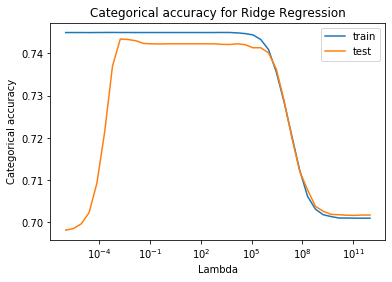

In [287]:
plt.plot(lambdas[:], accuracies_train_4[:], label="train")
plt.plot(lambdas[:], accuracies_test_4[:], label="test")
plt.xscale("log")
plt.xlabel("Lambda")
plt.ylabel("Categorical accuracy")
plt.title("Categorical accuracy for Ridge Regression")
plt.legend()
plt.show()

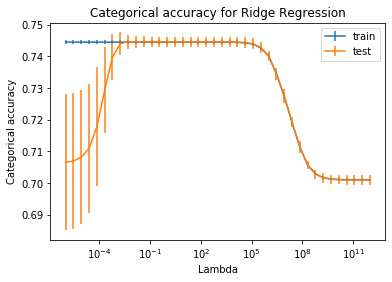

In [416]:
plt.errorbar(lambdas[:], accuracies_train_mean5[:], yerr=accuracies_train_std5[:], label="train")
plt.errorbar(lambdas[:], accuracies_test_mean5[:], yerr=accuracies_test_std5[:], label="test")
plt.xscale("log")
plt.xlabel("Lambda")
plt.ylabel("Categorical accuracy")
plt.title("Categorical accuracy for Ridge Regression")
plt.legend()
plt.show()

In [288]:
print("Best performance: lambda ", lambdas[np.argmax(accuracies_test_4)], ", train accuracy: ", accuracies_train_4[np.argmax(accuracies_test_4)], ", test accuracy: ", accuracies_test_4[np.argmax(accuracies_test_4)])

Best performance: lambda  0.0017012542798525892 , train accuracy:  0.74494034938219 , test accuracy:  0.7433976020738821


In [417]:
print("Best performance: lambda ", lambdas[np.argmax(accuracies_test_mean5)], ", train accuracy: ", accuracies_train_mean5[np.argmax(accuracies_test_mean5)], ", test accuracy: ", accuracies_test_mean5[np.argmax(accuracies_test_mean5)], ", std: ", accuracies_test_std5[np.argmax(accuracies_test_mean5)])

Best performance: lambda  0.11937766417144383 , train accuracy:  0.744487 , test accuracy:  0.7446280000000001 , std:  0.0016138203121785107


In [56]:
%time weights_RR = ridge_regression(y_train[0], x_train[0], 0.11937766417144383)[0]
print(weights_RR)

Wall time: 30.9 ms
[-3.13129997e-01  1.05477334e-02 -2.56440286e-01 -2.64020310e-01
 -3.80243113e-03  2.27707685e-02  8.92127465e-02  4.35586425e-03
  2.82055788e-01 -2.77491203e-02  1.58871333e-02 -1.87272958e-01
  1.17102028e-01  7.61181825e-02  1.83822255e-01 -1.39543135e-03
 -2.46968208e-03  2.85810288e-01 -5.34218801e-05  2.38845075e-03
  1.06418533e-01  2.17017576e-03 -4.91935951e-02  3.46967641e-02
 -5.17449693e-02  9.39311925e-04  4.96985538e-04 -4.05400326e-02
  1.49424114e-03 -5.36261692e-04  8.59141734e-03]


## Logistic regression

In [61]:
def logistic_regression_cv(y_train, x_train, w_i, max_iter, gamma):
    cat_accuracies_train = []
    cat_accuracies_test = []
    f1_scores_train = []
    f1_scores_test = []
    for i in range(num_folds):
        weights = logistic_regression(y_train[i], x_train[i], w_i, max_iter, gamma)[0]
        cat_accuracy_train, f1_score_train = metrics(y_train[i], predict_labels(weights, x_train[i]))
        cat_accuracy_test, f1_score_test = metrics(y_test[i], predict_labels(weights, x_test[i]))
        cat_accuracies_train.append(cat_accuracy_train)
        cat_accuracies_test.append(cat_accuracy_test)
        f1_scores_train.append(f1_score_train)
        f1_scores_test.append(f1_score_test)
    return cat_accuracies_train, cat_accuracies_test

In [220]:
y_train_log = np.copy(y_train)
y_train_log = np.where(y_train_log==-1, 0, y_train_log)

y_test_log = np.copy(y_test)
y_test_log = np.where(y_test_log==-1, 0, y_test_log)

gammas = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.31, 0.32, 0.33, 0.34, 0.4, 0.5]
weights_result_5 = []
accuracies_train_5 = []
accuracies_test_5 = []
for gamma in gammas:
    weights_LR = logistic_regression(y_train_log, x_train, np.zeros(31), 10000, gamma)[0]
    cat_accuracy_train, f1_score_train = metrics(y_train_log, predict_labels(weights_LR, x_train))
    cat_accuracy_test, f1_score_test = metrics(y_test_log, predict_labels(weights_LR, x_test))
    
    print("Gamma: " + str(gamma) + " || Categorical accuracy train : ",cat_accuracy_train," || f1_score train: ",f1_score_train)
    print("Gamma: " + str(gamma) + " || Categorical accuracy test : ",cat_accuracy_test," || f1_score test: ",f1_score_test)
    weights_result_5.append(weights_LR)
    accuracies_train_5.append(cat_accuracy_train)
    accuracies_test_5.append(cat_accuracy_test)
    
print(accuracies_train_5)
print(accuracies_test_5)

The loss for step 0 is 155989.9942229971.
The loss for step 1000 is 155986.6570715598.
The loss for step 2000 is 155982.98179237847.
The loss for step 3000 is 155980.06425238322.
The loss for step 4000 is 155976.5968732667.
The loss for step 5000 is 155973.095968284.
The loss for step 6000 is 155969.6429974646.
The loss for step 7000 is 155966.12319732865.
The loss for step 8000 is 155962.90345196048.
The loss for step 9000 is 155959.52730909263.
Gamma: 1e-07 || Categorical accuracy train :  0.7000702078686135  || f1_score train:  0.3066197633514551
Gamma: 1e-07 || Categorical accuracy test :  0.7009297106676284  || f1_score test:  0.3029107725788901
The loss for step 0 is 155989.96826378352.
The loss for step 1000 is 155956.79188752055.
The loss for step 2000 is 155923.7250396881.
The loss for step 3000 is 155889.3155319965.
The loss for step 4000 is 155858.36890505935.
The loss for step 5000 is 155824.44251516537.
The loss for step 6000 is 155791.68708996166.
The loss for step 7000 i

In [221]:
print("Best performance: gamma ", gammas[np.argmax(accuracies_test_5)], ", train accuracy: ", accuracies_train_5[np.argmax(accuracies_test_5)], ", test accuracy: ", accuracies_test_5[np.argmax(accuracies_test_5)])

Best performance: gamma  0.01 , train accuracy:  0.7480070741092932 , test accuracy:  0.7530656407790334


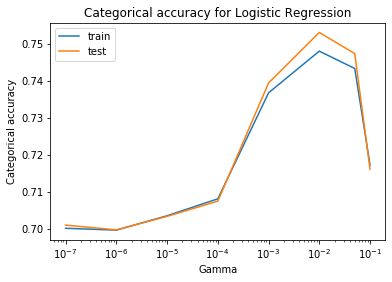

In [222]:
plt.plot(gammas[:8], accuracies_train_5[:8], label="train")
plt.plot(gammas[:8], accuracies_test_5[:8], label="test")
plt.xscale("log")
plt.xlabel("Gamma")
plt.ylabel("Categorical accuracy")
plt.title("Categorical accuracy for Logistic Regression")
plt.legend()
plt.show()

In [62]:
y_train_log = np.copy(y_train)
y_train_log = np.where(y_train_log==-1, 0, y_train_log)

y_test_log = np.copy(y_test)
y_test_log = np.where(y_test_log==-1, 0, y_test_log)

In [66]:
gammas = [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.35, 0.4, 0.5]
accuracies_train_mean6 = []
accuracies_test_mean6 = []
accuracies_train_std6 = []
accuracies_test_std6 = []
for gamma in gammas:
    cat_accuracies_train, cat_accuracies_test = logistic_regression_cv(y_train_log, x_train, np.zeros(31), 5000, gamma)
    
    print("Gamma: " + str(gamma) + " || Categorical accuracy train : (",np.mean(cat_accuracies_train),", ", np.std(cat_accuracies_train),")")
    print("Gamma: " + str(gamma) + " || Categorical accuracy test : (",np.mean(cat_accuracies_test),", ", np.std(cat_accuracies_test),")")
    accuracies_train_mean6.append(np.mean(cat_accuracies_train))
    accuracies_test_mean6.append(np.mean(cat_accuracies_test))
    accuracies_train_std6.append(np.std(cat_accuracies_train))
    accuracies_test_std6.append(np.std(cat_accuracies_test))
    
print(accuracies_train_mean6)
print(accuracies_test_mean6)
print(accuracies_train_std6)
print(accuracies_test_std6)

The loss for step 0 is 147005.43077788234.
The loss for step 500 is 173873.86903986018.
The loss for step 1000 is 173220.00586432236.
The loss for step 1500 is 149184.0855405997.
The loss for step 2000 is 136699.01978409037.
The loss for step 2500 is 140102.15854321962.
The loss for step 3000 is 129843.51219496729.
The loss for step 3500 is 126047.39225069282.
The loss for step 4000 is 141845.40856899193.
The loss for step 4500 is 152595.87276415888.
The loss for step 0 is 133769.89446855383.
The loss for step 500 is 131248.89635826973.
The loss for step 1000 is 190587.9012323714.
The loss for step 1500 is 137364.6946862666.
The loss for step 2000 is 132883.346348958.
The loss for step 2500 is 145768.37675616363.
The loss for step 3000 is 161200.7796164515.
The loss for step 3500 is 135991.13420186282.
The loss for step 4000 is 144532.83500636442.
The loss for step 4500 is 125255.23819831829.
The loss for step 0 is 133998.1594856299.
The loss for step 500 is 155048.37803205496.
The los

[0.7006840000000001, 0.7068329999999999, 0.725808, 0.739528, 0.7315039999999999, 0.7068109999999999, 0.702088, 0.684474, 0.68267, 0.652189, 0.695343]
[0.70082, 0.707164, 0.725564, 0.739304, 0.73182, 0.70634, 0.7013159999999999, 0.683836, 0.6835280000000001, 0.652492, 0.6955560000000001]
[0.0007671075543885681, 0.003416203448274102, 0.002934466902181688, 0.003534420178756334, 0.011746022901390901, 0.01715847236790035, 0.018109432514576477, 0.022947579915973695, 0.03351656948436099, 0.015829891471516797, 0.021463926155296024]
[0.0017847800984995613, 0.0035837946369734934, 0.0036046947166161036, 0.005038260017109079, 0.013401128310705779, 0.017216963727672792, 0.017749277844464527, 0.022375148357050057, 0.03389469244586828, 0.017691189219495678, 0.021948825572225942]


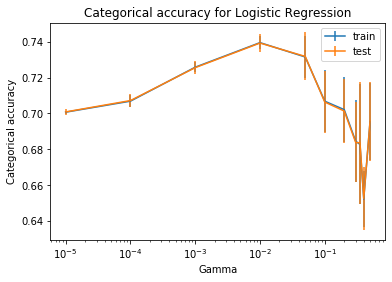

In [72]:
print(accuracies_train_mean6)
print(accuracies_test_mean6)
print(accuracies_train_std6)
print(accuracies_test_std6)

plt.errorbar(gammas[:], accuracies_train_mean6[:], yerr=accuracies_train_std6[:], label="train")
plt.errorbar(gammas[:], accuracies_test_mean6[:], yerr=accuracies_test_std6[:], label="test")
plt.xscale("log")
plt.xlabel("Gamma")
plt.ylabel("Categorical accuracy")
plt.title("Categorical accuracy for Logistic Regression")
plt.legend()
plt.show()

In [71]:
gammas = [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.35, 0.4, 0.5]
print("Best performance: gamma ", gammas[np.argmax(accuracies_train_mean6)], ", train accuracy: ", accuracies_train_mean6[np.argmax(accuracies_train_mean6)], ", test accuracy: ", accuracies_test_mean6[np.argmax(accuracies_train_mean6)], ", std: ", accuracies_train_std6[np.argmax(accuracies_train_mean6)])

Best performance: gamma  0.01 , train accuracy:  0.739528 , test accuracy:  0.739304 , std:  0.003534420178756334


In [58]:
y_train_log = np.copy(y_train)
y_train_log = np.where(y_train_log==-1, 0, y_train_log)

In [73]:
%time weights_LR = logistic_regression(y_train_log[0], x_train[0], np.zeros(31), 5000, 0.01)[0]
print(weights_LR)

The loss for step 0 is 138775.68988087037.
The loss for step 500 is 116744.65861552053.
The loss for step 1000 is 107442.8309220059.
The loss for step 1500 is 105252.11024957613.
The loss for step 2000 is 133121.13572423125.
The loss for step 2500 is 109985.98089335207.
The loss for step 3000 is 106524.08997813454.
The loss for step 3500 is 104502.68490073398.
The loss for step 4000 is 103164.36259639809.
The loss for step 4500 is 104326.57310225695.
Wall time: 1min 17s
[-0.90906672 -0.25327141 -0.69622693 -0.56236294  0.32446871 -0.10569927
  0.12432682 -0.06207718  0.79446163 -0.08182467  0.07363604 -0.46041125
  0.33356426  0.0354029   0.47751836  0.00794709 -0.00415608  0.3314193
  0.15561382  0.01637708  0.17182487  0.09943165 -0.34730518  0.03544712
 -0.18954729  0.00555886 -0.09720198 -0.15257085  0.11811588 -0.09703519
 -0.09681555]


## Regularized logistic regression

In [101]:
def reg_logistic_regression_cv(y_train, x_train, lambda_, w_i, max_iter, gamma):
    cat_accuracies_train = []
    cat_accuracies_test = []
    f1_scores_train = []
    f1_scores_test = []
    for i in range(num_folds):
        weights = reg_logistic_regression(y_train[i], x_train[i], lambda_, w_i, max_iter, gamma)[0]
        cat_accuracy_train, f1_score_train = metrics(y_train[i], predict_labels(weights, x_train[i]))
        cat_accuracy_test, f1_score_test = metrics(y_test[i], predict_labels(weights, x_test[i]))
        cat_accuracies_train.append(cat_accuracy_train)
        cat_accuracies_test.append(cat_accuracy_test)
        f1_scores_train.append(f1_score_train)
        f1_scores_test.append(f1_score_test)
    return cat_accuracies_train, cat_accuracies_test

In [104]:
%time weights_RLR = reg_logistic_regression(y_train_log[0], x_train[0], 0.01, np.zeros(31), 5000, 0.01)[0]
print(weights_RLR)

The loss for step 0 is 138094.39284539782.
The loss for step 500 is 110774.99091734077.
The loss for step 1000 is 106794.78351195043.
The loss for step 1500 is 105122.93973763101.
The loss for step 2000 is 105697.87315580342.
The loss for step 2500 is 104763.20706231704.
The loss for step 3000 is 108441.4842630534.
The loss for step 3500 is 103710.67729831095.
The loss for step 4000 is 103002.93284247883.
The loss for step 4500 is 104949.70863596132.
Wall time: 1min 24s
[-0.68670293 -0.01873236 -0.58381652 -0.34170032  0.08434848  0.07012641
  0.28795161  0.02719103  0.51828044 -0.12703247  0.16964973 -0.41195066
  0.32552896  0.20793587  0.49672123 -0.04047384 -0.0842403   0.31357342
  0.03929911 -0.0482054   0.1442309   0.11073408 -0.0161264   0.0298651
  0.00185587  0.03930165 -0.04049998 -0.16759714 -0.06650038  0.0398133
  0.0162456 ]


In [102]:
gammas = [0.001, 0.01, 0.05]
lambdas = np.logspace(-2, 2, 3)
accuracies_train_mean7 = []
accuracies_train_std7 = []
accuracies_test_mean7 = []
accuracies_test_std7 = []
for lambda_ in lambdas:
    accuracy_train = []
    accuracy_test = []
    weights = []
    for gamma in gammas:
        cat_accuracies_train, cat_accuracies_test = reg_logistic_regression_cv(y_train_log, x_train, lambda_, np.zeros(31), 5000, gamma)

        print("Lambda: " + str(lambda_) + "Gamma: " + str(gamma) + " || Categorical accuracy train : (",np.mean(cat_accuracies_train),", ", np.std(cat_accuracies_train),")")
        print("Lambda: " + str(lambda_) + "Gamma: " + str(gamma) + " || Categorical accuracy test : (",np.mean(cat_accuracies_test),", ", np.std(cat_accuracies_test),")")
        accuracies_train_mean7.append(np.mean(cat_accuracies_train))
        accuracies_test_mean7.append(np.mean(cat_accuracies_test))
        accuracies_train_std7.append(np.std(cat_accuracies_train))
        accuracies_test_std7.append(np.std(cat_accuracies_test))


The loss for step 0 is 138666.6603444086.
The loss for step 500 is 126949.72278931359.
The loss for step 1000 is 121379.85563202035.
The loss for step 1500 is 118041.29009851534.
The loss for step 2000 is 115602.27426073822.
The loss for step 2500 is 113647.21854068818.
The loss for step 3000 is 112284.72542397924.
The loss for step 3500 is 111010.61631400573.
The loss for step 4000 is 110237.23416583946.
The loss for step 4500 is 109782.0488742209.
The loss for step 0 is 138600.65850651692.
The loss for step 500 is 129896.58137887983.
The loss for step 1000 is 124060.06335768841.
The loss for step 1500 is 119642.11521976437.
The loss for step 2000 is 116818.54006013751.
The loss for step 2500 is 115251.61187760512.
The loss for step 3000 is 113831.68181245294.
The loss for step 3500 is 112654.77696883136.
The loss for step 4000 is 111562.14050698013.
The loss for step 4500 is 110364.36336241734.
The loss for step 0 is 138667.05733324005.
The loss for step 500 is 128930.27239554406.
Th

C:\Users\ruben\git\ML\implementations.py:121: RuntimeWarning: overflow encountered in double_scalars
  loss = compute_loss_log_reg(y,tx,w) + lambda_/2*np.dot(w.T,w)


The loss for step 500 is inf.


C:\Users\ruben\git\ML\implementations.py:299: RuntimeWarning: overflow encountered in multiply
  grad = compute_gradient_log_reg(y[rand_ind], tx[rand_ind], ws) + lambda_*ws


The loss for step 1000 is nan.
The loss for step 1500 is nan.
The loss for step 2000 is nan.
The loss for step 2500 is nan.
The loss for step 3000 is nan.
The loss for step 3500 is nan.
The loss for step 4000 is nan.
The loss for step 4500 is nan.


C:\Users\ruben\git\ML\proj1_helpers.py:157: RuntimeWarning: invalid value encountered in less_equal
  y_pred[np.where(y_pred <= 0)] = -1
C:\Users\ruben\git\ML\proj1_helpers.py:158: RuntimeWarning: invalid value encountered in greater
  y_pred[np.where(y_pred > 0)] = 1


The loss for step 0 is 135605.3353897098.
The loss for step 500 is inf.


C:\Users\ruben\git\ML\implementations.py:300: RuntimeWarning: invalid value encountered in subtract
  ws = ws - gamma*grad


The loss for step 1000 is nan.
The loss for step 1500 is nan.


KeyboardInterrupt: 

In [191]:
best_index = np.unravel_index(np.argmax(np.matrix(accuracies_test_6), axis=None), np.matrix(accuracies_test_6).shape)
print(np.argmax(accuracies_test_6))
print("Best performance: lambda ", lambdas[best_index[0]], ", gamma: ", gammas[best_index[1]], ", train accuracy: ", accuracies_train_6[best_index], ", test accuracy: ", accuracies_test_6[best_index])

0


TypeError: list indices must be integers or slices, not tuple

In [103]:
print("Best performance: train accuracy: ", accuracies_train_mean7[np.argmax(accuracies_train_mean7)], ", test accuracy: ", accuracies_test_mean7[np.argmax(accuracies_train_mean7)], ", std: ", accuracies_test_std7[np.argmax(accuracies_train_mean7)])

Best performance: train accuracy:  0.7397349999999999 , test accuracy:  0.7401359999999999 , std:  0.0027695313683004366


In [60]:
%time weights_RLR = reg_logistic_regression(y_train_log[0], x_train[0], 1, np.zeros(31), 10000, 0.01)[0]
print(weights_RLR)

The loss for step 0 is 137897.0621101196.
The loss for step 1000 is 125609.45562772293.
The loss for step 2000 is 124730.19686155011.
The loss for step 3000 is 123550.60856625027.
The loss for step 4000 is 123886.0378161571.
The loss for step 5000 is 123615.80558740675.
The loss for step 6000 is 125856.5924602007.
The loss for step 7000 is 123543.49426173672.
The loss for step 8000 is 121206.11214924582.
The loss for step 9000 is 124525.76837883987.
Wall time: 2min 37s
[-0.11314409  0.01622702 -0.13391721 -0.01178004  0.02223444  0.06053401
  0.04859322 -0.06130088  0.0235683  -0.01720906  0.04047576 -0.02854431
  0.06744779  0.08116625  0.03234255  0.00225212 -0.04502771  0.00105355
 -0.01207135  0.06345276 -0.08170612 -0.01022218  0.00730209  0.05748577
  0.00542862  0.01541223 -0.01201087  0.00792681 -0.01296452  0.04492941
  0.040195  ]


# Advanced models

## Categorical splitting

In [94]:
x_train_0 = []
x_train_1 = []
x_train_2 = []
x_train_3 = []
y_train_0 = []
y_train_1 = []
y_train_2 = []
y_train_3 = []
x_test_0 = []
x_test_1 = []
x_test_2 = []
x_test_3 = []
y_test_0 = []
y_test_1 = []
y_test_2 = []
y_test_3 = []
for i in range(num_folds):
    # Split the rows base on categories of 22th column of features which is the number of jets       
    rows0 = x_train_ns[i][:,23]==0
    rows1 = x_train_ns[i][:,23]==1
    rows2 = x_train_ns[i][:,23]==2
    rows3 = x_train_ns[i][:,23]==3
    y0, x0 = y_train[i][rows0], x_train[i][np.where(rows0)]
    y1, x1 = y_train[i][rows1], x_train[i][np.where(rows1)]
    y2, x2 = y_train[i][rows2], x_train[i][np.where(rows2)]
    y3, x3 = y_train[i][rows3], x_train[i][np.where(rows3)]
    x_train_0.append(x0)
    x_train_1.append(x1)
    x_train_2.append(x2)
    x_train_3.append(x3)
    y_train_0.append(y0)
    y_train_1.append(y1)
    y_train_2.append(y2)
    y_train_3.append(y3)
    
     # Split the TESTrows base on categories of 22th column of features which is the number of jets       
    rows0 = x_test_ns[i][:,22]==0
    rows1 = x_test_ns[i][:,23]==1
    rows2 = x_test_ns[i][:,23]==2
    rows3 = x_test_ns[i][:,23]==3
    y0, x0 = y_test[i][rows0], x_test[i][np.where(rows0)]
    y1, x1 = y_test[i][rows1], x_test[i][np.where(rows1)]
    y2, x2 = y_test[i][rows2], x_test[i][np.where(rows2)]
    y3, x3 = y_test[i][rows3], x_test[i][np.where(rows3)]
    x_test_0.append(x0)
    x_test_1.append(x1)
    x_test_2.append(x2)
    x_test_3.append(x3)
    y_test_0.append(y0)
    y_test_1.append(y1)
    y_test_2.append(y2)
    y_test_3.append(y3)


In [96]:
cat0 = 99913.0 / 250000
cat1 = 77544.0 / 250000
cat2 = 50379.0 / 250000
cat3 = 22164.0 / 250000
lambdas =  np.logspace(-6, 12, 40)

accuracies_train_mean8 = []
accuracies_test_mean8 = []
accuracies_train_std8 = []
accuracies_test_std8 = []

for lambda_ in lambdas:
    cat_accuracies_train, cat_accuracies_test = ridge_regression_cv(y_train_0, x_train_0, y_test_0, x_test_0, lambda_)
    
    print("Lambda: " + str(lambda_) + " || Categorical accuracy train : (",np.mean(cat_accuracies_train),", ", np.std(cat_accuracies_train),")")
    print("Lambda: " + str(lambda_) + " || Categorical accuracy test : (",np.mean(cat_accuracies_test),", ", np.std(cat_accuracies_test),")")
    accuracies_train_mean8.append(np.mean(cat_accuracies_train))
    accuracies_test_mean8.append(np.mean(cat_accuracies_test))
    accuracies_train_std8.append(np.std(cat_accuracies_train))
    accuracies_test_std8.append(np.std(cat_accuracies_test))
    
    print("Best performance: lambda ", lambdas[np.argmax(accuracies_test_mean8)], ", train accuracy: ", accuracies_train_mean8[np.argmax(accuracies_test_mean8)], ", test accuracy: ", accuracies_test_mean8[np.argmax(accuracies_test_mean8)], ", std: ", accuracies_test_std8[np.argmax(accuracies_test_mean8)])
    cat_accuracies_test0 = accuracies_test_mean8[np.argmax(accuracies_test_mean8)]
    cat_accuracies_test0_std = accuracies_test_std8[np.argmax(accuracies_test_mean8)]

accuracies_train_mean8 = []
accuracies_test_mean8 = []
accuracies_train_std8 = []
accuracies_test_std8 = []

for lambda_ in lambdas:
    cat_accuracies_train, cat_accuracies_test = ridge_regression_cv(y_train_1, x_train_1, y_test_1, x_test_1, lambda_)
    
    print("Lambda: " + str(lambda_) + " || Categorical accuracy train : (",np.mean(cat_accuracies_train),", ", np.std(cat_accuracies_train),")")
    print("Lambda: " + str(lambda_) + " || Categorical accuracy test : (",np.mean(cat_accuracies_test),", ", np.std(cat_accuracies_test),")")
    accuracies_train_mean8.append(np.mean(cat_accuracies_train))
    accuracies_test_mean8.append(np.mean(cat_accuracies_test))
    accuracies_train_std8.append(np.std(cat_accuracies_train))
    accuracies_test_std8.append(np.std(cat_accuracies_test))
    
    print("Best performance: lambda ", lambdas[np.argmax(accuracies_test_mean8)], ", train accuracy: ", accuracies_train_mean8[np.argmax(accuracies_test_mean8)], ", test accuracy: ", accuracies_test_mean8[np.argmax(accuracies_test_mean8)], ", std: ", accuracies_test_std8[np.argmax(accuracies_test_mean8)])
    cat_accuracies_test1 = accuracies_test_mean8[np.argmax(accuracies_test_mean8)]
    cat_accuracies_test1_std = accuracies_test_std8[np.argmax(accuracies_test_mean8)]

accuracies_train_mean8 = []
accuracies_test_mean8 = []
accuracies_train_std8 = []
accuracies_test_std8 = []

for lambda_ in lambdas:
    cat_accuracies_train, cat_accuracies_test = ridge_regression_cv(y_train_2, x_train_2, y_test_2, x_test_2, lambda_)
    
    print("Lambda: " + str(lambda_) + " || Categorical accuracy train : (",np.mean(cat_accuracies_train),", ", np.std(cat_accuracies_train),")")
    print("Lambda: " + str(lambda_) + " || Categorical accuracy test : (",np.mean(cat_accuracies_test),", ", np.std(cat_accuracies_test),")")
    accuracies_train_mean8.append(np.mean(cat_accuracies_train))
    accuracies_test_mean8.append(np.mean(cat_accuracies_test))
    accuracies_train_std8.append(np.std(cat_accuracies_train))
    accuracies_test_std8.append(np.std(cat_accuracies_test))
    
    print("Best performance: lambda ", lambdas[np.argmax(accuracies_test_mean8)], ", train accuracy: ", accuracies_train_mean8[np.argmax(accuracies_test_mean8)], ", test accuracy: ", accuracies_test_mean8[np.argmax(accuracies_test_mean8)], ", std: ", accuracies_test_std8[np.argmax(accuracies_test_mean8)])
    cat_accuracies_test2 = accuracies_test_mean8[np.argmax(accuracies_test_mean8)]
    cat_accuracies_test2_std = accuracies_test_std8[np.argmax(accuracies_test_mean8)]

accuracies_train_mean8 = []
accuracies_test_mean8 = []
accuracies_train_std8 = []
accuracies_test_std8 = []

for lambda_ in lambdas:
    cat_accuracies_train, cat_accuracies_test = ridge_regression_cv(y_train_3, x_train_3, y_test_3, x_test_3, lambda_)
    
    print("Lambda: " + str(lambda_) + " || Categorical accuracy train : (",np.mean(cat_accuracies_train),", ", np.std(cat_accuracies_train),")")
    print("Lambda: " + str(lambda_) + " || Categorical accuracy test : (",np.mean(cat_accuracies_test),", ", np.std(cat_accuracies_test),")")
    accuracies_train_mean8.append(np.mean(cat_accuracies_train))
    accuracies_test_mean8.append(np.mean(cat_accuracies_test))
    accuracies_train_std8.append(np.std(cat_accuracies_train))
    accuracies_test_std8.append(np.std(cat_accuracies_test))
    
    print("Best performance: lambda ", lambdas[np.argmax(accuracies_test_mean8)], ", train accuracy: ", accuracies_train_mean8[np.argmax(accuracies_test_mean8)], ", test accuracy: ", accuracies_test_mean8[np.argmax(accuracies_test_mean8)], ", std: ", accuracies_test_std8[np.argmax(accuracies_test_mean8)])
    cat_accuracies_test3 = accuracies_test_mean8[np.argmax(accuracies_test_mean8)]
    cat_accuracies_test3_std = accuracies_test_std8[np.argmax(accuracies_test_mean8)]

cat_accuracies_test = cat_accuracies_test0 * cat0 + cat_accuracies_test1 * cat1 + cat_accuracies_test2 * cat2 + cat_accuracies_test3 * cat3
cat_accuracies_test_std = cat_accuracies_test0_std * cat0 + cat_accuracies_test1_std * cat1 + cat_accuracies_test2_std * cat2 + cat_accuracies_test3_std * cat3
print(cat_accuracies_test, " ", cat_accuracies_test_std)

ZeroDivisionError: division by zero

## Combining smaller categories

In [ ]:
x_train_0 = []
x_train_1 = []
x_train_2 = []
y_train_0 = []
y_train_1 = []
y_train_2 = []
x_test_0 = []
x_test_1 = []
x_test_2 = []
y_test_0 = []
y_test_1 = []
y_test_2 = []
for i in range(num_folds):
    # Split the rows base on categories of 22th column of features which is the number of jets       
    rows0 = x_train[i][:,22]==0
    rows1 = x_train[i][:,22]==1
    rows2 = np.logical_or(tx[:,22]==2, tx[:,22]==3)
    y0, x0 = y_train[rows0], x_train[np.where(rows0)]
    y1, x1 = y_train[rows1], x_train[np.where(rows1)]
    y2, x2 = y_train[rows2], x_train[np.where(rows2)]
    x_train_0.append(x0)
    x_train_1.append(x1)
    x_train_2.append(x2)
    y_train_0.append(y0)
    y_train_1.append(y1)
    y_train_2.append(y2)
    
    # Split the TESTrows base on categories of 22th column of features which is the number of jets       
    rows0 = x_test[i][:,22]==0
    rows1 = x_test[i][:,22]==1
    rows2 = x_test[i][:,22]==0
    y0, x0 = y_test[rows0], x_test[np.where(rows0)]
    y1, x1 = y_test[rows1], x_test[np.where(rows1)]
    y2, x2 = y_test[rows2], x_test[np.where(rows2)]
    x_test_0.append(x0)
    x_test_1.append(x1)
    x_test_2.append(x2)
    y_test_0.append(y0)
    y_test_1.append(y1)
    y_test_2.append(y2)


In [ ]:
cat0 = 99913.0 / 250000
cat1 = 77544.0 / 250000
cat2 = 50379.0 / 250000
cat3 = 22164.0 / 250000
lambdas =  np.logspace(-6, 12, 40)

accuracies_train_mean8 = []
accuracies_test_mean8 = []
accuracies_train_std8 = []
accuracies_test_std8 = []

for lambda_ in lambdas:
    cat_accuracies_train, cat_accuracies_test = ridge_regression_cv(y_train_0, x_train_0, y_test_0, x_test_0, lambda_)
    
    print("Lambda: " + str(lambda_) + " || Categorical accuracy train : (",np.mean(cat_accuracies_train),", ", np.std(cat_accuracies_train),")")
    print("Lambda: " + str(lambda_) + " || Categorical accuracy test : (",np.mean(cat_accuracies_test),", ", np.std(cat_accuracies_test),")")
    accuracies_train_mean8.append(np.mean(cat_accuracies_train))
    accuracies_test_mean8.append(np.mean(cat_accuracies_test))
    accuracies_train_std8.append(np.std(cat_accuracies_train))
    accuracies_test_std8.append(np.std(cat_accuracies_test))
    
    print("Best performance: lambda ", lambdas[np.argmax(accuracies_test_mean8)], ", train accuracy: ", accuracies_train_mean8[np.argmax(accuracies_test_mean8)], ", test accuracy: ", accuracies_test_mean8[np.argmax(accuracies_test_mean8)], ", std: ", accuracies_test_std8[np.argmax(accuracies_test_mean8)])
    cat_accuracies_test0 = accuracies_test_mean8[np.argmax(accuracies_test_mean8)]
    cat_accuracies_test0_std = accuracies_test_std8[np.argmax(accuracies_test_mean8)]

accuracies_train_mean8 = []
accuracies_test_mean8 = []
accuracies_train_std8 = []
accuracies_test_std8 = []

for lambda_ in lambdas:
    cat_accuracies_train, cat_accuracies_test = ridge_regression_cv(y_train_1, x_train_1, y_test_1, x_test_1, lambda_)
    
    print("Lambda: " + str(lambda_) + " || Categorical accuracy train : (",np.mean(cat_accuracies_train),", ", np.std(cat_accuracies_train),")")
    print("Lambda: " + str(lambda_) + " || Categorical accuracy test : (",np.mean(cat_accuracies_test),", ", np.std(cat_accuracies_test),")")
    accuracies_train_mean8.append(np.mean(cat_accuracies_train))
    accuracies_test_mean8.append(np.mean(cat_accuracies_test))
    accuracies_train_std8.append(np.std(cat_accuracies_train))
    accuracies_test_std8.append(np.std(cat_accuracies_test))
    
    print("Best performance: lambda ", lambdas[np.argmax(accuracies_test_mean8)], ", train accuracy: ", accuracies_train_mean8[np.argmax(accuracies_test_mean8)], ", test accuracy: ", accuracies_test_mean8[np.argmax(accuracies_test_mean8)], ", std: ", accuracies_test_std8[np.argmax(accuracies_test_mean8)])
    cat_accuracies_test1 = accuracies_test_mean8[np.argmax(accuracies_test_mean8)]
    cat_accuracies_test1_std = accuracies_test_std8[np.argmax(accuracies_test_mean8)]

accuracies_train_mean8 = []
accuracies_test_mean8 = []
accuracies_train_std8 = []
accuracies_test_std8 = []

for lambda_ in lambdas:
    cat_accuracies_train, cat_accuracies_test = ridge_regression_cv(y_train_2, x_train_2, y_test_2, x_test_2, lambda_)
    
    print("Lambda: " + str(lambda_) + " || Categorical accuracy train : (",np.mean(cat_accuracies_train),", ", np.std(cat_accuracies_train),")")
    print("Lambda: " + str(lambda_) + " || Categorical accuracy test : (",np.mean(cat_accuracies_test),", ", np.std(cat_accuracies_test),")")
    accuracies_train_mean8.append(np.mean(cat_accuracies_train))
    accuracies_test_mean8.append(np.mean(cat_accuracies_test))
    accuracies_train_std8.append(np.std(cat_accuracies_train))
    accuracies_test_std8.append(np.std(cat_accuracies_test))
    
    print("Best performance: lambda ", lambdas[np.argmax(accuracies_test_mean8)], ", train accuracy: ", accuracies_train_mean8[np.argmax(accuracies_test_mean8)], ", test accuracy: ", accuracies_test_mean8[np.argmax(accuracies_test_mean8)], ", std: ", accuracies_test_std8[np.argmax(accuracies_test_mean8)])
    cat_accuracies_test2 = accuracies_test_mean8[np.argmax(accuracies_test_mean8)]
    cat_accuracies_test2_std = accuracies_test_std8[np.argmax(accuracies_test_mean8)]

cat_accuracies_test = cat_accuracies_test0 * cat0 + cat_accuracies_test1 * cat1 + cat_accuracies_test2 * cat2
cat_accuracies_test_std = cat_accuracies_test0_std * cat0 + cat_accuracies_test1_std * cat1 + cat_accuracies_test2_std * cat2
print(cat_accuracies_test, " ", cat_accuracies_test_std)

## Polynomial regression

In [ ]:
def poly_ridge_regression_cv(y_train, x_train, y_test, x_test, lambda_, degree):
    cat_accuracies_train = []
    cat_accuracies_test = []
    f1_scores_train = []
    f1_scores_test = []
    for i in range(num_folds):
        x_train_poly = build_poly(copy.deepcopy(x_train[i]), degree)
        weights = ridge_regression(y_train[i], x_train_poly, lambda_)[0]
        cat_accuracy_train, f1_score_train = metrics(y_train[i], predict_labels(weights, x_train[i]))
        cat_accuracy_test, f1_score_test = metrics(y_test[i], predict_labels(weights, x_test[i]))
        cat_accuracies_train.append(cat_accuracy_train)
        cat_accuracies_test.append(cat_accuracy_test)
        f1_scores_train.append(f1_score_train)
        f1_scores_test.append(f1_score_test)
    return cat_accuracies_train, cat_accuracies_test